In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from PINGU.importer import *
from PINGU.processer import *
from PINGU.main import get_all_events,get_events
from functions import perform_chisq
from DC.event_processing import list_of_params_nsi,get_param_list, get_best_fit
from PINGU.event_processing import return_precomputed_nsi, get_deltachi, to_hist
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [2]:
ndim = 3
livetime = 3*365*24*3600 #Effective livetime table1 DC2019 2.45
precomputed_events = True
IO=False
dm31_range, th23_range,ett_range, emt_range, eem_range, eet_range = get_param_list(dm31N=5, th23N=5, 
                                                                                       ett=5e-2, ettN=5, 
                                                                                       emt=2e-2, emtN=1, 
                                                                                       eem=2e-1, eemN=1, 
                                                                                       eet=2e-1, eetN=1, 
                                                                                       IO=IO)

print('dm:', dm31_range)
print('th:', th23_range)
print('ett:', ett_range)
print('emt:', emt_range)
print('eem:', eem_range)
print('eet:', eet_range)
param_dict = nufit_params_nsi_IO if IO else nufit_params_nsi

param_list = list_of_params_nsi(param_dict, dm31_range, th23_range, ett_range, emt_range, eem_range, eet_range)

dm: [0.002435   0.00248933 0.002517   0.00254367 0.002598  ]
th: [0.69987703 0.76736309 0.83484916 0.85870199 0.90233522]
ett: [-0.05       -0.01666667  0.          0.01666667  0.05      ]
emt: [0.]
eem: [0.]
eet: [0.]


In [3]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    data_H1 = [(p, pid,True) for p in param_list]
    data_H0 = [(Ebin,zbin,param_list[0],pid,False) for Ebin in range(8) for zbin in range(8)]
    p = Pool()
    H1_events_list = p.starmap(get_all_events, data_H1)
    #H0_events = p.starmap(get_events, data_H0)
    p.close()
    #H0_events = np.array(H0_events).reshape(8,8)
    pickle.dump(H1_events_list,open(f'./pre_computed/H1_PINGU_{pid}_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','wb'))
    #pickle.dump(H0_events,open(f'./pre_computed/H0_PINGU_{pid}.p','wb'))


H1_list = [pickle.load(open(f'./pre_computed/H1_PINGU_{pid}_{len(dm31_range)}x{len(th23_range)}x{len(ett_range)}x{len(emt_range)}x{len(eem_range)}x{len(eet_range)}.p','rb')) for pid in [0,1]]
H0_list = [pickle.load(open(f'./pre_computed/H0_PINGU_{pid}.p','rb')) for pid in [0,1]]
H1 = np.array(H1_list)*livetime
H0 = np.array(H0_list)*livetime
H1 = np.swapaxes(H1,0,1)


'''
no_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])
no_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])
H0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])
events = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])
background = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])
best_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017

data = np.sum(events,axis=2)

H0_factors = H0_paper / np.sum(H0,axis=2)
noosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axis=2)*livetime) #can laos use best_fit_contamination here

# Normalize NSI hypothesis
H1_nonorm = H1 #No normalization
H1_norm_H0 = H1 * H0_factors[None,:,None,:] #Norm against H0
H1_norm_noosc = H1*noosc_factors[None,:,None,:] # Norm against no oscillation
'''

"\nno_osc = np.array([get_all_events(params=param_list[0], pid=0, nsi=True, no_osc=True),get_all_events(params=param_list[0], pid=1, nsi=True, no_osc=True)])\nno_osc_paper = np.array([no_osc2018_DC(0)[1].values,no_osc2018_DC(1)[1].values])\nH0_paper = np.array([pd.read_csv('./src/data/files/DC/2018/cascade_H0.csv', header=None)[1].values,pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values])\nevents = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_events'),get_hist(events2018_DC().query(f'pid==1'), 'count_events')])\nbackground = np.array([get_hist(events2018_DC().query(f'pid==0'), 'count_background'), get_hist(events2018_DC().query(f'pid==1'), 'count_background')])\nbest_fit_contamination = 0.055/(np.sum(background,axis=(1,2))/np.sum(events,axis=(1,2))) #table 1 DC2017\n\ndata = np.sum(events,axis=2)\n\nH0_factors = H0_paper / np.sum(H0,axis=2)\nnoosc_factors = (no_osc_paper - back_factor.reshape(-1,1)*np.sum(background,axis=2)) / (np.sum(no_osc,axi

In [4]:
sigma_a = 0.25
sigma_b = 0.04
f = 0
chisq,  best_fit_index = get_deltachi([H for H in H1],H0,0,[sigma_a,sigma_b],f,x0=[1,0])

reshaped_chisq = chisq.reshape(len(emt_range), len(ett_range), len(th23_range), len(dm31_range)) #reshaped_chisq[emt,emm,th23,dm31]
minimum_ax_0_and_1 = np.min(reshaped_chisq,axis=(0,1)).reshape(1,1,len(th23_range),len(dm31_range))
deltachi = reshaped_chisq - minimum_ax_0_and_1


best_emt_index,best_ett_index,best_th23_index, best_dm31_index = np.unravel_index(best_fit_index,deltachi.shape)
best_dm31, best_th23, best_ett, best_emt = dm31_range[best_dm31_index], th23_range[best_th23_index],ett_range[best_ett_index],emt_range[best_emt_index]
best_fit_params = param_list[best_fit_index]

assert best_fit_params['dm_31'] == best_dm31 
assert best_fit_params['theta_23'] == best_th23
assert best_fit_params['e_mm'] == -best_ett #e' = emm-ett, and emm=0
assert best_fit_params['e_mt'] == best_emt

marginalized_deltachi = deltachi[:,:,best_th23_index,best_dm31_index]

In [5]:
best_fit_params

{'theta_12': 0.5836381018669037,
 'theta_13': 0.14957471689591406,
 'theta_23': 0.834849158870621,
 'theta_34': 0.0,
 'theta_24': 0.2013579207903308,
 'theta_14': 0.0,
 'delta_ij': 3.4033920413889422,
 'dm_21': 7.42e-05,
 'dm_31': 0.002435,
 'dm_41': 0.93,
 'e_ee': -0.016666666666666663,
 'e_em': 0.0,
 'e_et': 0.0,
 'e_mm': -0.016666666666666663,
 'e_mt': 0.0,
 'e_tt': 0,
 'e_es': 0,
 'e_ms': 0,
 'e_ts': 0,
 'e_ss': 0}

In [6]:
marginalized_deltachi

array([[10.64605882,  1.02598204,  0.25778614,  0.        ,  2.53809785]])

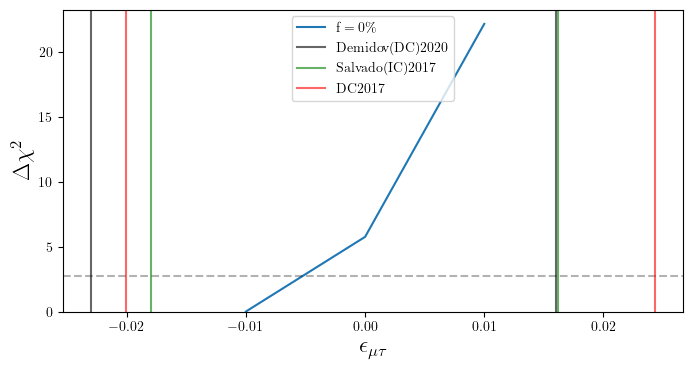

In [6]:
salvado = (-6e-3*3, 5.4e-3*3)
dc_2017 = (-6.7e-3*3, 8.1e-3*3)
demidov = (-0.023, 0.016)
plt.plot(emt_range, marginalized_deltachi[:,best_emm_index],label=r'$\mathrm{f = 0\%}$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='black', label=r'$\mathrm{Demidov (DC) 2020}$')
plt.axvline(demidov[1], alpha=0.6,c='black')

plt.axvline(salvado[0], alpha=0.6,c='green', label=r'$\mathrm{Salvado (IC) 2017}$')
plt.axvline(dc_2017[0], alpha=0.6,c='red', label=r'$\mathrm{DC 2017}$')
plt.axvline(dc_2017[1], alpha=0.6,c='red')
plt.axvline(salvado[1], alpha=0.6,c='green')

#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\epsilon_{\mu\tau}$', fontsize=17)
plt.ylabel(r'$\Delta \chi^2$', fontsize=17)
plt.legend()

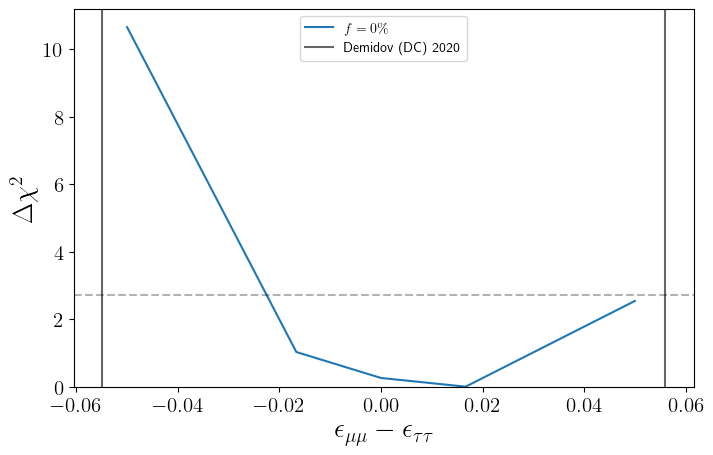

In [7]:
demidov = (-0.055, 0.056)
fig, ax = plt.subplots(1,1,figsize=(8,5))
plt.plot(ett_range, marginalized_deltachi[best_emt_index],label=r'$f = 0\%$')
#plt.plot(emt_range, deltachi1,label='My work, f = 5 \%')
plt.axhline(chi2.ppf(0.9,1), alpha=0.3, c='black', ls = '--')
#plt.axhline(chi2.ppf(0.99,1), alpha=0.3, c='black', ls = '--')
plt.axvline(demidov[0], alpha=0.6,c='black', label=r'Demidov (DC) 2020')
plt.axvline(demidov[1], alpha=0.6,c='black')


#plt.text(0.0085,chi2.ppf(q = 0.90,df=1)+0.2,'90\% CL',rotation=0,fontsize=10,alpha = 0.5)
#plt.text(-0.0107,chi2.ppf(q = 0.99,df=1)+0.2,'99\% CL',rotation=0,fontsize=10,alpha = 0.5)
plt.ylim(bottom=0)
#plt.xlim((emt_range.min(), emt_range.max()))
plt.xlabel(r'$\epsilon_{\mu\mu} - \epsilon_{\tau\tau}$', fontsize=20)
plt.ylabel(r'$\Delta \chi^2$', fontsize=20)
plt.tick_params(labelsize=15)
plt.legend()
#fig.savefig('./latex/article/figures/PINGU_emm.pdf')

In [11]:
get_best_fit(marginalized_deltachi, dm31_range, 0.9)
get_best_fit(marginalized_deltachi, th23_range, 0.9)
get_best_fit(marginalized_deltachi, ett_range, 0.9)

(0.002, 0.002)

<ipython-input-14-b2d50a1ef21e>:2: UserWarning: The following kwargs were not used by contour: 'label'
  no_err = ax.contour(marginalized_deltachi.T,levels = [chi2.ppf(q=0.9, df = 2)], label='No exp. uncert.')


"\nfmt_noerr = {}\nstrs = ['f=0 \\%']#,'f = 5 \\%']\nfor l, s in zip(no_err.levels, strs):\n    fmt_noerr[l] = s\n\nfmt_fiverr = {}\nstrs = ['f=5 \\%']\nfor l, s in zip(five_err.levels, strs):\n    fmt_fiverr[l] = s\n\nax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)\nax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)\n"

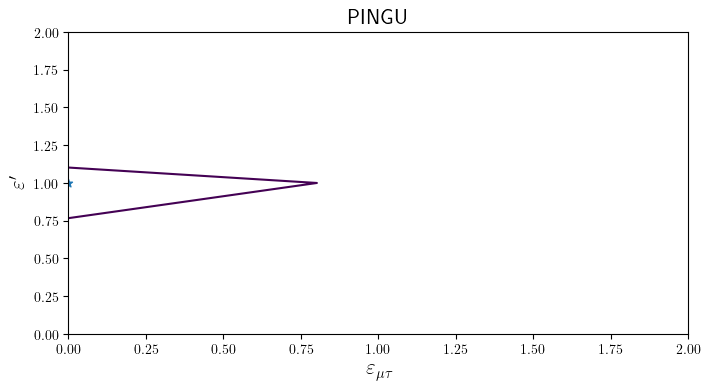

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
no_err = ax.contour(marginalized_deltachi.T,levels = [chi2.ppf(q=0.9, df = 2)], label='No exp. uncert.')
#five_err = ax.contour(deltachi1.T,levels = [chi2.ppf(q=0.9, df = 2)], label='5 \% exp. uncert.', color='orange')
ax.scatter(best_emt_index,best_emm_index, marker='*')
#_=ax.set_xticklabels(labels=np.round(emt_range,3))
#_=ax.set_yticklabels(labels=np.round(emm_range,3))
ax.set_xlabel(r'$\varepsilon_{\mu\tau}$', fontsize=15)
ax.set_ylabel(r'$\varepsilon^\prime$', fontsize=15)
plt.title(r'PINGU', fontsize=15)

'''
fmt_noerr = {}
strs = ['f=0 \%']#,'f = 5 \%']
for l, s in zip(no_err.levels, strs):
    fmt_noerr[l] = s

fmt_fiverr = {}
strs = ['f=5 \%']
for l, s in zip(five_err.levels, strs):
    fmt_fiverr[l] = s

ax.clabel(no_err, no_err.levels, inline=True, fmt=fmt_noerr, fontsize=10)
ax.clabel(five_err, five_err.levels, inline=True, fmt=fmt_fiverr, fontsize=10)
'''

In [18]:
reshaped_params = np.array(param_list).reshape(len(emt_range), len(emm_range), len(th23_range), len(dm31_range))

In [44]:
emt_min_index = np.ravel_multi_index((0,best_emm_index,best_th23_index,best_dm31_index), (len(emt_range), len(emm_range), len(th23_range), len(dm31_range)))
emt_SI_index = np.ravel_multi_index((int(len(emt_range)/2),int(len(emm_range)/2),best_th23_index,best_dm31_index), (len(emt_range), len(emm_range), len(th23_range), len(dm31_range)))
emt_max_index = np.ravel_multi_index((len(emt_range)-1,best_emm_index,best_th23_index,best_dm31_index), (len(emt_range), len(emm_range), len(th23_range), len(dm31_range)))

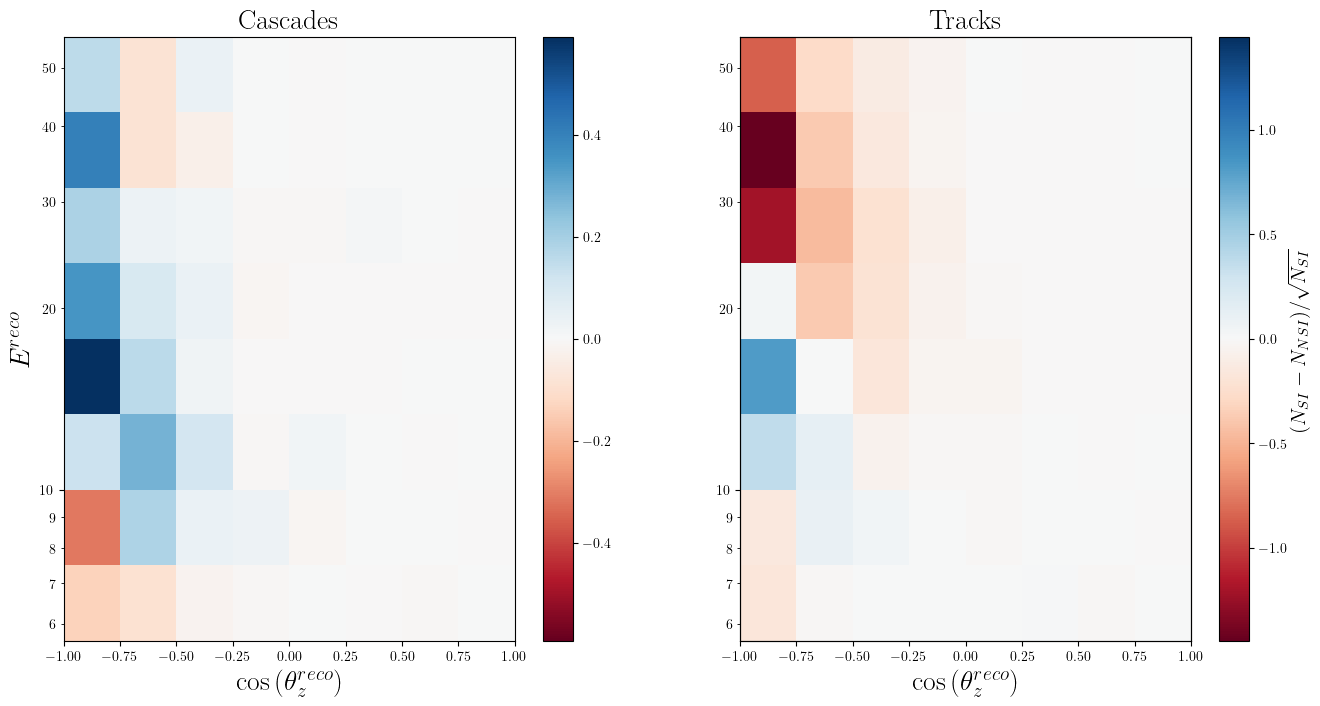

In [51]:
from matplotlib.colors import CenteredNorm
N_NSI_left = H1[emt_min_index]
N_NSI_right = H1[emt_max_index]
N_SI = H1[emt_SI_index] #H0
pull_min = (N_SI - N_NSI_left)/np.sqrt(N_SI)
pull_max = (N_SI - N_NSI_right)/np.sqrt(N_SI)
pull_diff = (N_NSI_left - N_NSI_right)/np.sqrt(N_SI)

titles = [r'$\mathrm{Cascades}$', r'$\mathrm{Tracks}$']
fig, ax = plt.subplots(1,2,figsize=(16,8))
for pid in [0,1]:
    ax[pid].set_title(titles[pid], fontsize=20)
    im = ax[pid].pcolormesh(zbins_2018,Ebins_2018, pull_min[pid], cmap='RdBu', norm= CenteredNorm(0))
    ax[pid].set_yscale('log')
    plt.colorbar(im, ax=ax[pid])
    ax[pid].set_xlabel(r'$\cos{(\theta^{reco}_z)}$', fontsize=20)
    
    ax[pid].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[pid].get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    #ax[pid].ticklabel_format(style='sci',axis='y')
    #ax[pid].tick_params(which='both',labelsize=13)
    ax[pid].set_yticks([10])
ax[0].set_ylabel(r'$E^{reco}$', fontsize=20)
ax2 = ax[1].twinx()
ax2.set_yticks([])
ax2.set_ylabel(r'$(N_{SI} - N_{NSI})/\sqrt{N_{SI}}$', fontsize=15, labelpad= 70)
#plt.suptitle(r'$[N(\epsilon_{\mu\tau}^-) - N(\epsilon_{\mu\tau}^+)]/\sqrt{N_{SI}}$ PINGU',fontsize=20)

fig.savefig('latex/article/figures/PINGU_event_pulls.pdf')
from subprocess import call 
_ = call('pdfcrop latex/article/figures/PINGU_event_pulls.pdf latex/article/figures/PINGU_event_pulls.pdf')